# Instalacja pakietów

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform
import scipy.stats as stats
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import random

In [2]:
plt.rcParams['text.usetex'] = True

# Funkcje pomocnicze

## Liczba rozmyta trójkątna (ang. Triangular Fuzzy Number, TFN)

In [3]:
class TriangularFuzzyNumber:
    # For the trinagular fuzzy number to be well-defined its parameters a,b,c need to be increasing
    def __init__(self, a, b, c):
        if a >= b or b >= c:
            raise ValueError("Niewłaściwe wartości parametrów.")
        self.a = a
        self.b = b
        self.c = c

    # Mebership function of a triangular fuzzy number
    def membership(self, x):
        if x < self.a or x > self.c:
            return 0.0
        elif x >= self.a and x <= self.b:
            return (x - self.a) / (self.b - self.a)
        elif x >= self.b and x <= self.c:
            return (self.c - x) / (self.c - self.b)

    # Function to plot the membership function of a triangular fuzzy number    
    def plot(self, label=None, color=None, alpha=None):

        if color is None:
            color = 'royalblue'
        if alpha is None:
            alpha = 1
        x_values = np.linspace(self.a - 1, self.c + 1, 1000)
        membership_values = [self.membership(x) for x in x_values]

        plt.plot(x_values, membership_values, label=label, color=color, alpha=alpha)

    # Credibility distribution of a triangular fuzzy number
    def calculate_cred_distr(self, x):
        result = np.zeros_like(x)
        result[(self.a <= x) & (x <= self.b)] = (x[(self.a <= x) & (x <= self.b)] - self.a) / (2 * (self.b - self.a))
        result[(self.b < x) & (x < self.c)] = (x[(self.b < x) & (x < self.c)] + self.c - 2 * self.b) / (2 * (self.c - self.b))
        result[x >= self.c] = 1
        return result

    
    # Function to plot the credibility distribution of a triangular fuzzy number    
    def plot_cred_distr(self, x_min=None, x_max=None, num_points=100, label=None, color=None, alpha=None):
        
        if color is None:
            color = 'royalblue'
        if alpha is None:
            alpha = 1
        if x_min is None:
            x_min = self.a
        if x_max is None:
            x_max = self.c
        x = np.linspace(x_min, x_max, num_points)
        y = self.calculate_cred_distr(x)

        plt.plot(x, y,label=label,color=color, alpha=alpha)

    # Inverse credibility distribution of a triangular fuzzy number
    def calculate_cred_distr_inv(self, y):
        result = np.zeros_like(y)
        result[y <= 0] = self.a
        result[(y > 0) & (y <= 0.5)] = self.a + 2 * (self.b - self.a) * y[(y > 0) & (y <= 0.5)]
        result[(y > 0.5) & (y < 1)] = self.b + 2 * (self.c - self.b) * (y[(y > 0.5) & (y < 1)] - 0.5)
        result[y >= 1] = self.c
        return result

    # Function to plot the inverse credibility distribution of a triangular fuzzy number    
    def plot_cred_distr_inv(self, y_min=0, y_max=1, num_points=100, label=None, color=None, alpha=None):

        if color is None:
            color = 'royalblue'
        if alpha is None:
            alpha = 1
        y = np.linspace(y_min, y_max, num_points)
        x = self.calculate_cred_distr_inv(y)

        plt.plot(y, x, label=label,color=color, alpha=alpha)

    # Function to convert the prameters of a triangular fuzzy number to array 
    def to_array(self):
        # Converts the triangular fuzzy number into a numpy array
        return np.array([self.a, self.b, self.c])

## Generowanie z rozkładów

Funkcja do generowania liczb typu TFN. Przykładowo, jądro $b$ is pochodzi z rozkładu normalnego zadanego przez parametry $\mu$ i $\sigma.$ Odległości punktów $a$ i $c$ od $b$ mają rozład jednostajny na odpowiednio $[0, \delta_1]$ i $[0,\delta_2].$ 

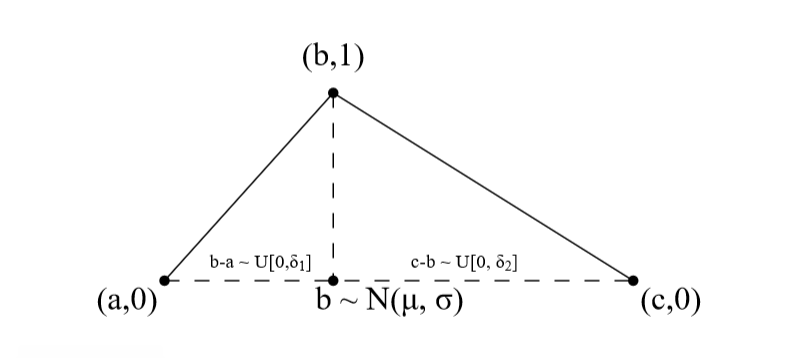|

In [4]:
def generate_TFN(dist, delta_1, delta_2, sample_size=1000, 
                 plot =False, if_mixture=False, shift=0, 
                 mixture_proportion=0.5, **params):

    dist_obj = getattr(stats, dist)
    tfns = []

    if if_mixture:
        # Ensure mixture_proportion is between 0 and 1
        if not (0 <= mixture_proportion <= 1):
            raise ValueError("mixture_proportion must be between 0 and 1")

        # Determine the number of samples for each distribution
        size_1 = int(sample_size * (1-mixture_proportion))
        size_2 = sample_size - size_1

        # Generate samples for the first distribution
        b_1 = dist_obj.rvs(size=size_1, **params)

        # Generate samples for the second (shifted) distribution
        shifted_params = params.copy()
        shifted_params['loc'] = params.get('loc', 0) + shift
        b_2 = dist_obj.rvs(size=size_2, **shifted_params)

        # Combine the samples from both distributions
        b = np.concatenate([b_1, b_2])
    else:
        
        b = dist_obj.rvs(size=sample_size, **params)

    # Vectorized generation of xi_1 and xi_2
    xi_1 = stats.uniform.rvs(loc=0.000001, scale=delta_1, size=sample_size)
    xi_2 = stats.uniform.rvs(loc=0.000001, scale=delta_2, size=sample_size)
        
    # Calculate a and c
    a = b - xi_1
    c = b + xi_2
        
    # Create TriangularFuzzyNumbers
    tfns = [TriangularFuzzyNumber(a[i], b[i], c[i]) for i in range(sample_size)]
    
    if plot:
        plt.figure(figsize=(8, 6))
        for tfn in tfns:
            tfn.plot()  
        plt.xlabel('$x$', fontsize=16)
        plt.ylabel('$\mu(x)$',fontsize=16)
        plt.grid(True)
        plt.show()

    return tfns

Średnia z próbki liczb typu TFN

In [5]:
def mean_TFN(tfns):

    mean_a = np.mean([tfn.a for tfn in tfns])
    mean_b = np.mean([tfn.b for tfn in tfns])
    mean_c = np.mean([tfn.c for tfn in tfns])

    return TriangularFuzzyNumber(mean_a, mean_b, mean_c)

# Dystanse

Odległość $L^2$ pomiędzy wykresami odwrotnych rozkładów wiarygodności dla TFN

In [6]:
def TFN_l2_distance(tfn1: TriangularFuzzyNumber, tfn2: TriangularFuzzyNumber):
    a1 = tfn1.a
    b1 = tfn1.b
    c1 = tfn1.c
    a2 = tfn2.a
    b2 = tfn2.b
    c2 = tfn2.c
    distance = ((b1-a1-b2+a2)**2)/6 + (b1-a1-b2+a2)*(a1-a2)/2 + ((a1-a2)**2)/2 + (7/6)*(c1-b1-c2+b2)**2 + (3/2)*(c1-b1-c2+b2)*(2*(b1-b2)-(c1-c2)) + (1/2)*(2*(b1-b2)-(c1-c2))**2
    return distance

Odległość energetyczna dla liczb rozmytych trójkątnych. Domyślna wartość wagi $\theta$ to $1.$

In [7]:
def TFN_distance_giletal(tfn1: TriangularFuzzyNumber, tfn2: TriangularFuzzyNumber, theta: float = 1):
    
    a1 = tfn1.a
    b1 = tfn1.b
    c1 = tfn1.c
    a2 = tfn2.a
    b2 = tfn2.b
    c2 = tfn2.c

    mid_0_1 = (a1+c1)/2 # midpoint of the support
    mid_1_1= b1 # midpoint of the core
    spr_0_1 = c1-a1 # spread of the support
    spr_1_1 = 0 # spread of the core

    mid_0_2 = (a2+c2)/2
    mid_1_2= b2
    spr_0_2 = c2-a2
    spr_1_2 = 0

    distance = (((mid_0_1-mid_0_2)**2)/3 + ((mid_1_1-mid_1_2)**2)/3 + (mid_0_1-mid_0_2)*(mid_1_1-mid_1_2)/3 + theta*((spr_0_1-spr_0_2)**2
    )/3 + theta*((spr_1_1-spr_1_2)**2)/3 + theta*((spr_0_1-spr_0_2)*(spr_1_1-spr_1_2))/3)**0.5

    return distance

## Porównywanie

In [8]:
def TFN_credibility_index(tfn1: TriangularFuzzyNumber, tfn2: TriangularFuzzyNumber):
        
    a1 = tfn1.a
    b1 = tfn1.b
    c1 = tfn1.c
    a2 = tfn2.a
    b2 = tfn2.b
    c2 = tfn2.c

    if b1 < b2 and c1 <= a2:
        return 0.0
    elif b1 < b2 and c1 > a2:
        h = (c1*b2 - a2*b1)/(b2-a2-b1+c1)
        return (h-c1)/(2* (b1-c1))
    elif b1 == b2:
        return 0.5
    elif b1 > b2 and a1 < c2:
        h = (a1*b2 - c2*b1)/(b2-c2-b1+a1)
        return 1-(h-a1)/(2* (b1-a1))
    elif b1 > b2 and a1 >= c2:
        return 1.0

# Testowanie hipotez

## Generowanie próbek

### Rozkład normalny

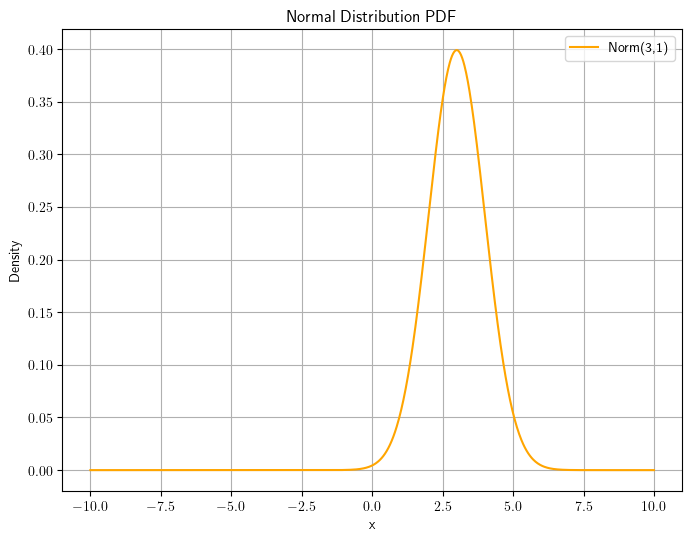

In [ ]:
mean = 3  
st_dev = 1  

norm_dist = stats.norm(loc = mean, scale=st_dev)

x = np.linspace(-10, 10, 1000)
pdf_values = norm_dist.pdf(x)

plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label=f'Norm({mean},{st_dev})', color='orange')
plt.title('Normal Distribution PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

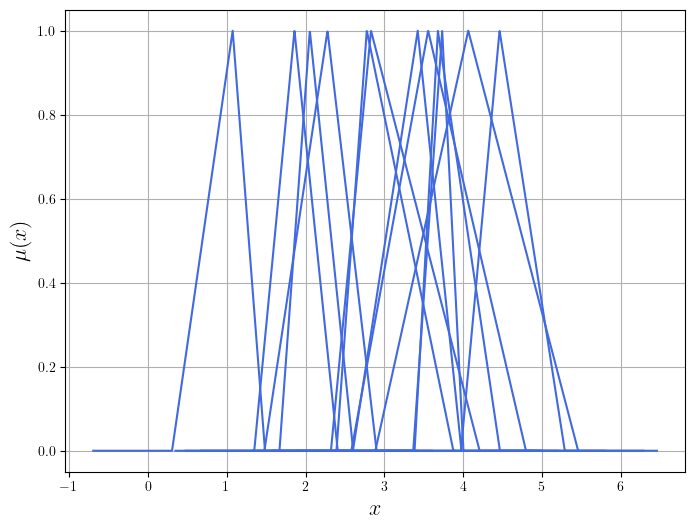

In [ ]:
tfns_norm = generate_TFN('norm',delta_1 = 1.2, delta_2= 1.4, sample_size=12, plot=True, loc=3, scale=1)

### Rozkład wykładniczy

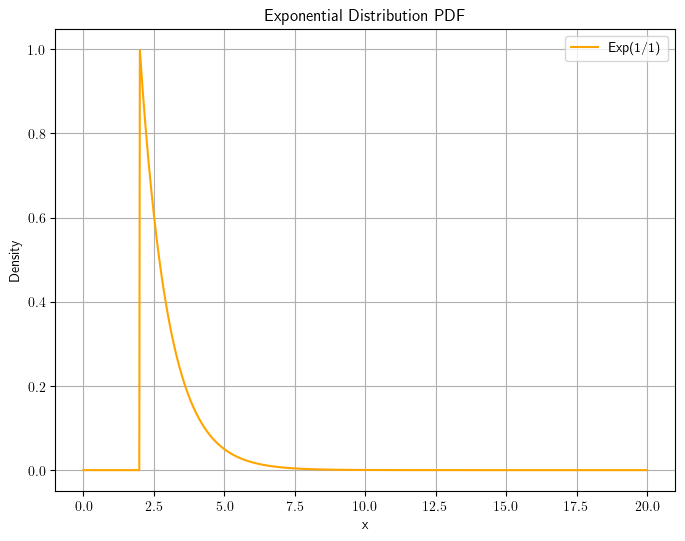

In [ ]:
loc = 2  # 
scale = 1  # 1/lambda

expon_dist = stats.expon(loc = loc, scale=scale)

x = np.linspace(0, 20, 1000)
pdf_values = expon_dist.pdf(x)

plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label=f'Exp(1/{scale})', color='orange')
plt.title('Exponential Distribution PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

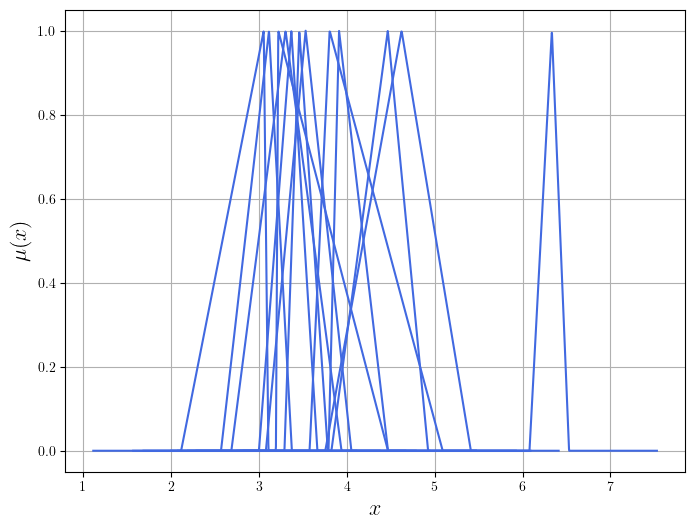

In [ ]:
tfns_expon = generate_TFN('expon',delta_1 = 1.2, delta_2= 1.4, sample_size=12, plot=True, loc=3, scale=1)

### Rozkład gamma

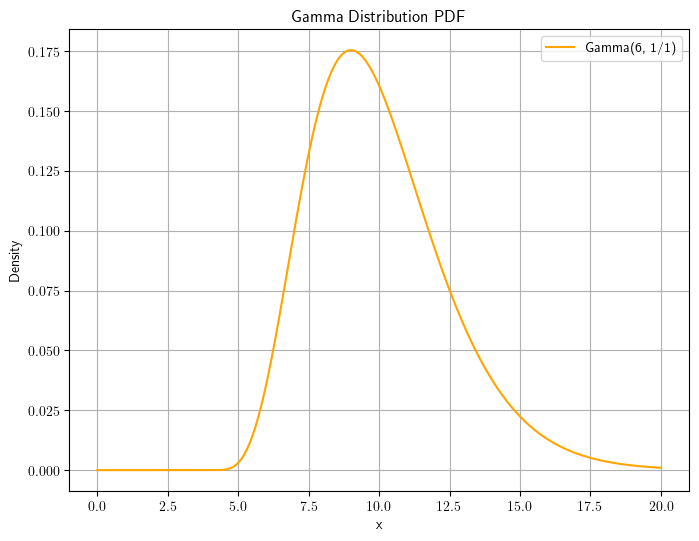

In [ ]:
alpha = 6 # 
scale = 1  # 1/beta -> beta  =1/scale
loc = 4

gamma_dist = stats.gamma(a=alpha, scale=scale, loc=loc)

x = np.linspace(0, 20, 1000)
pdf_values = gamma_dist.pdf(x)

# Plot the PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label=f'Gamma({alpha}, 1/{scale})', color='orange')
plt.title('Gamma Distribution PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

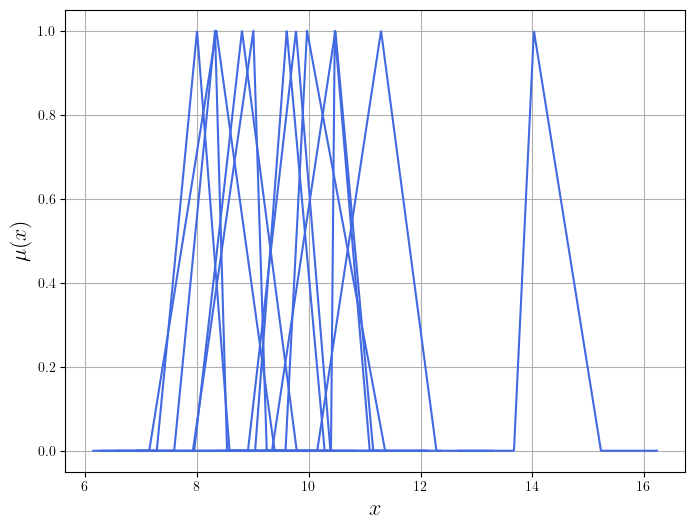

In [ ]:
tfns_gamma = generate_TFN('gamma',delta_1 = 1.2, delta_2= 1.4, sample_size=12, plot=True, a=5, loc=5, scale=1)

### Rozkład Chi kwadrat

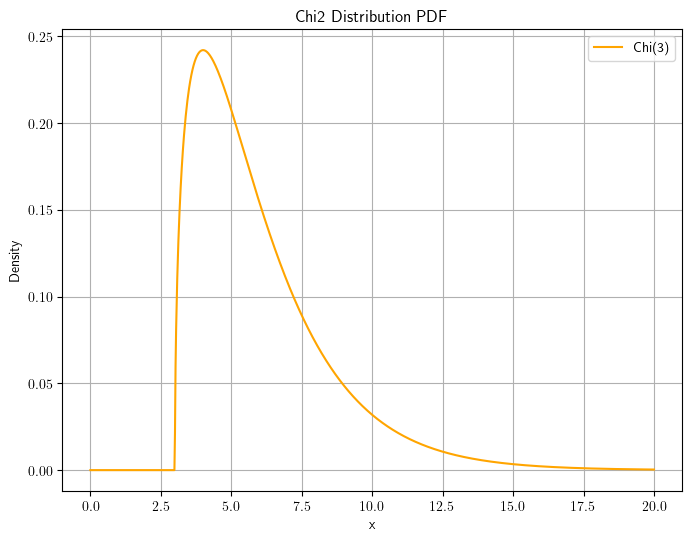

In [ ]:
df= 3  
loc = 3

chi2_dist = stats.chi2(df=df, loc=loc)

x = np.linspace(0, 20, 1000)
pdf_values = chi2_dist.pdf(x)

# Plot the PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label=f'Chi({df})', color='orange')
plt.title('Chi2 Distribution PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

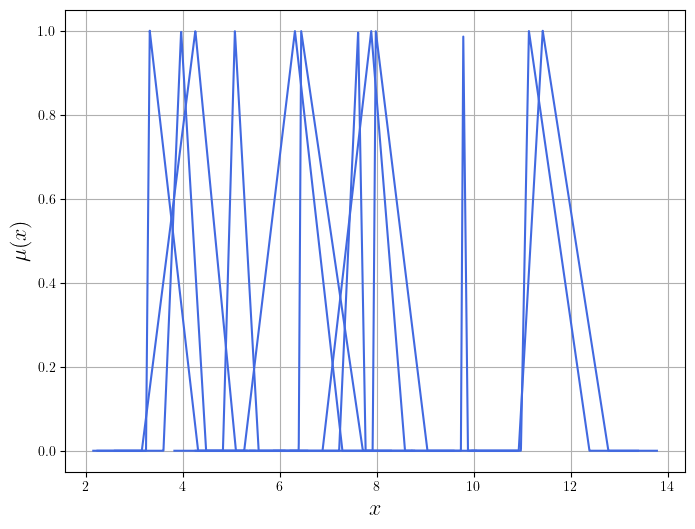

In [ ]:
tfns_chi2 = generate_TFN('chi2',delta_1 = 1.2, delta_2= 1.4, sample_size=12, plot=True, df=df, loc=3)

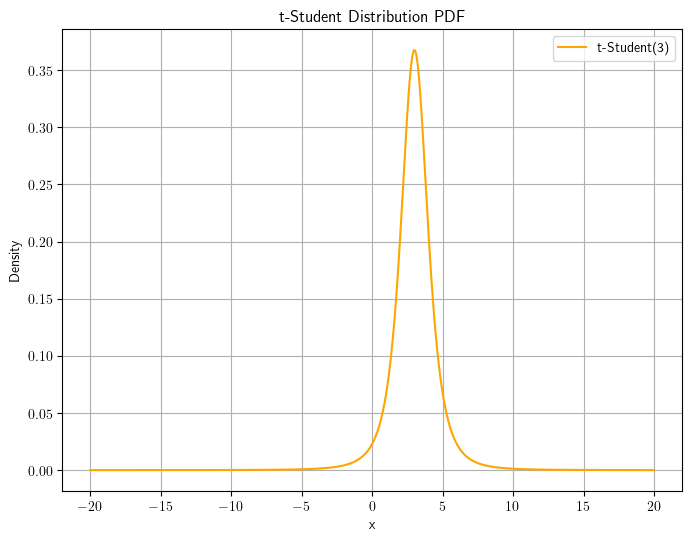

In [ ]:
df= 3  
loc = 3

t_dist = stats.t(df=df, loc=loc)

x = np.linspace(-20, 20, 1000)
pdf_values = t_dist.pdf(x)

# Plot the PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label=f't-Student({df})', color='orange')
plt.title('t-Student Distribution PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

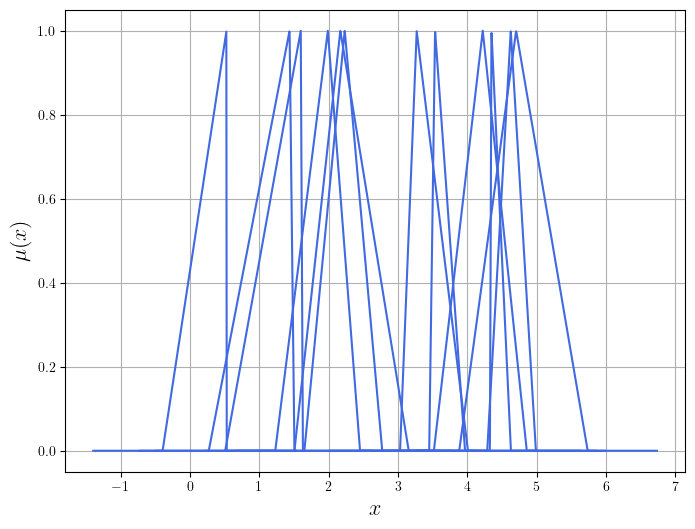

In [ ]:
tfns_t = generate_TFN('t',delta_1 = 1.2, delta_2= 1.4, sample_size=12, plot=True, df=df, loc=3)

## Statystyki testowe

Statystyka dla liczb trójkątnych bazująca na odległości $L^2$ zaproponowana w mojej pracy

In [9]:
def TFN_statistic(sample1, sample2):

    # L2 distance between the means of each sample is calculated 
    statistic = TFN_l2_distance(mean_TFN(sample1), mean_TFN(sample2))
    
    return statistic

Statystyka testowa dla liczb trójkątnych bazująca na odległości zaproponowanej w pracy *Permutation k-sample Goodness-of-Fit Test for Fuzzy Data*

In [10]:
def TFN_statistic_pgrzeg(sample1, sample2):
        
    # Sizes of the samples
    n = len(sample1)
    m = len(sample2)

    # Mean of the pooled sample
    mean_combined_samples = mean_TFN(np.concatenate([sample1, sample2]))

    # Test statistic is the sum of weighted squares of the earlier defined distance proposed by przgeg, same one as used in 
    # previous statistic.
    # For simplified implementation, the mean of the pooled samples is always evaluated, though it is constant despite pooling.
    # This causes a slight increase in the needed computations.
    statistic =n*TFN_distance_giletal(mean_TFN(sample1), mean_combined_samples)**2 + m*TFN_distance_giletal(
    mean_TFN(sample2), mean_combined_samples)**2
    
    return statistic

Statystyka testowa dla liczb trójkątnych bazująca na odległości energetycznej Szekelego i Rizzo

In [12]:
def TFN_statistic_szekely(sample1, sample2):
    n = len(sample1)
    m = len(sample2)


    XY_term =  0 
    XX_term =  0 
    YY_term =  0 
    
    for idx1, tfn_x_1 in enumerate(sample1):
        for tfn_y_2 in sample2:

            energy_distance = TFN_distance_giletal(tfn_x_1, tfn_y_2)
            XY_term  += energy_distance

        for idx2, tfn_x_2 in enumerate(sample1):

            energy_distance = TFN_distance_giletal(tfn_x_1, tfn_x_2)
            
            if idx2 < idx1:
                XX_term  += 2*energy_distance
            elif idx1 == idx2:
                XX_term  += energy_distance
            else:
                break
            

    for idx1, tfn_y_1 in enumerate(sample2):
        for idx2, tfn_y_2 in enumerate(sample2):

            energy_distance = TFN_distance_giletal(tfn_y_1, tfn_y_2)
            
            if idx2 < idx1:
                YY_term  += 2*energy_distance
            elif idx1 == idx2:
                YY_term  += energy_distance
            else:
                break

    statistic = (n*m)/(n+m)*(2*XY_term/(n*m)-XX_term/n**2-YY_term/m**2)

    return statistic
    

Uogólniona statystyka testowa Manna-Whitneya (Milena)

In [22]:
def TFN_statistic_milena(sample1, sample2):
    n = len(sample1)
    m = len(sample2)

    statistic =  0 
    
    for tfn_x_1 in sample1:
        for tfn_y_2 in sample2:

            credibility_index = TFN_credibility_index(tfn_x_1, tfn_y_2)
            statistic  += credibility_index

    return statistic

Statystyka testowa dla liczb trójkątnych bazująca na odległości zaproponowanej w pracy *k-Nearest Neighbors Test for Fuzzy Data*

In [32]:
def TFN_statistic_knn(sample1, sample2, k=5):

    # Pooled sample
    combined_samples = np.concatenate([sample1, sample2])
    
    # Sizes of the samples
    sample1_size = len(sample1)
    sample2_size = len(sample2)

    # Labels: 0 stands for the first sample, 1 for the second sample
    labels = np.array([0] * sample1_size + [1] * sample2_size)
    
    # For calculation purposes the tfns need to be converted to arrays (tfn objects are problematic for the future use)
    combined_samples_array = np.array([s.to_array() for s in combined_samples])
    
    # Nearest neighbors algorithm to find the closest k neighbors in terms of our defined metric
    # Lambda function had to be used since user-implmented metric is not working properly
    nbrs = NearestNeighbors(n_neighbors=k, metric=lambda x, y: TFN_distance_giletal(TriangularFuzzyNumber(*x), TriangularFuzzyNumber(*y)))
    nbrs.fit(combined_samples_array)
    
    # The indexes of the k neighbors of each element in the sample
    indices = nbrs.kneighbors(combined_samples_array, return_distance=False)
    
    # Loop to count neighbors that belong to the sample
    same_sample_counts = 0
    for idx, neighbors in enumerate(indices):
        current_label = labels[idx]
        same_sample_count = np.sum(labels[neighbors] == current_label)
        same_sample_counts += same_sample_count
    
    test_statistic = same_sample_counts / (k * (sample1_size + sample2_size))
    
    return test_statistic

Statystyka punktowa A. Kozak i P. Grzegorzewski

In [31]:
def TFN_statistic_kozak(sample1, sample2):

    sample1_size = len(sample1)
    sample2_size = len(sample2)

    alphas = np.linspace(0,1,1000)

    inv_distr_mean_1 = np.mean([tfn1.calculate_cred_distr_inv(alphas) for tfn1 in sample1],axis= 0)
    inv_distr_mean_2 = np.mean([tfn2.calculate_cred_distr_inv(alphas) for tfn2 in sample2],axis= 0)

    st_dev_1 = np.std([tfn1.calculate_cred_distr_inv(alphas) for tfn1 in sample1],axis=0,ddof= 1)
    st_dev_2 = np.std([tfn2.calculate_cred_distr_inv(alphas) for tfn2 in sample2],axis=0,ddof= 1)

    t_alphas = np.abs( inv_distr_mean_1-inv_distr_mean_2)/(1/sample1_size*st_dev_1 + 1/sample2_size*st_dev_2)**0.5

    statistic = np.max(t_alphas)
    
    return statistic

## Test

In [33]:
def permutation_test(sample1, sample2, statistic, 
                     num_permutations=1000, plot_histogram=False):
    
    # Combine the samples
    combined_samples = np.concatenate([sample1, sample2])

    # Observed test statistic
    observed_statistic =statistic(sample1, sample2)

    # Initialize array to store permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    for i in range(num_permutations):
        # Permute the combined samples
        permuted_samples = np.random.permutation(combined_samples)

        # Compute the test statistic for permuted samples
        permuted_sample1 = permuted_samples[:len(sample1)]
        permuted_sample2 = permuted_samples[len(sample1):]
        permuted_statistics[i] = statistic(permuted_sample1, permuted_sample2)

    # Compute the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)

    if plot_histogram:
        plt.hist(permuted_statistics, bins=50, color='skyblue', edgecolor='black')
        plt.xlabel('Wartości statystyk')
        plt.ylabel('Czestotliwość')
        plt.title('Histogram statystyk testowych')
        plt.axvline(np.abs(observed_statistic), color='red', linestyle='--', label='Wyjściowa wartość statystyki')
        plt.legend()
        plt.show()

    return p_value

### Nowa implemetacja testu dla k najbliższych sąsiadów

In [34]:
def count_matching_labels(neighbors, labels):

    same_sample_counts = 0
    for idx, neighbors in enumerate(neighbors):
        current_label = labels[idx]
        same_sample_count = np.sum(labels[neighbors] == current_label)
        same_sample_counts += same_sample_count
    
    return same_sample_counts

In [35]:
def permutation_test_knn(sample1, sample2, k=5, num_permutations=1000, plot_histogram=False):
    
    # Pooled sample
    combined_samples = np.concatenate([sample1, sample2])
    
    # Sizes of the samples
    sample1_size = len(sample1)
    sample2_size = len(sample2)

    # Labels: 0 stands for the first sample, 1 for the second sample
    labels = np.array([0] * sample1_size + [1] * sample2_size)
    
    # For calculation purposes the tfns need to be converted to arrays (tfn objects are problematic for the future use)
    combined_samples_array = np.array([s.to_array() for s in combined_samples])
    
    # Nearest neighbors algorithm to find the closest k neighbors in terms of our defined metric
    # Lambda function had to be used since user-implmented metric is not working properly
    nbrs = NearestNeighbors(n_neighbors=k, metric=lambda x, y: TFN_distance_giletal(TriangularFuzzyNumber(*x), TriangularFuzzyNumber(*y)))
    nbrs.fit(combined_samples_array)
    
    # The indexes of the k neighbors of each element in the sample
    neighbors = nbrs.kneighbors(combined_samples_array, return_distance=False)

    observed_statistic =  count_matching_labels(neighbors, labels) / (k * (sample1_size + sample2_size))

    # Initialize array to store permuted test statistics
    permuted_statistics = np.zeros(num_permutations)

    for i in range(num_permutations):
        
        #new_labels = random.sample(labels, len(labels))
        np.random.shuffle(labels)
        permuted_statistics[i] = count_matching_labels(neighbors, labels) / (k * (sample1_size + sample2_size))

    # Compute the p-value
    p_value = np.mean(permuted_statistics >= observed_statistic)

    if plot_histogram:
        plt.hist(permuted_statistics, bins=50, color='skyblue', edgecolor='black')
        plt.xlabel('Wartości statystyk')
        plt.ylabel('Czestotliwość')
        plt.title('Histogram statystyk testowych')
        plt.axvline(np.abs(observed_statistic), color='red', linestyle='--', label='Wyjściowa wartość statystyki')
        plt.legend()
        plt.show()

    return p_value

###  Działanie testów

In [47]:
tfns_1 = generate_TFN('chi2',delta_1 = 0.6, delta_2= 0.5, sample_size=25, df=3)
tfns_2 = generate_TFN('chi2',delta_1 = 0.5, delta_2= 0.6, sample_size=25, df=3, loc=3)

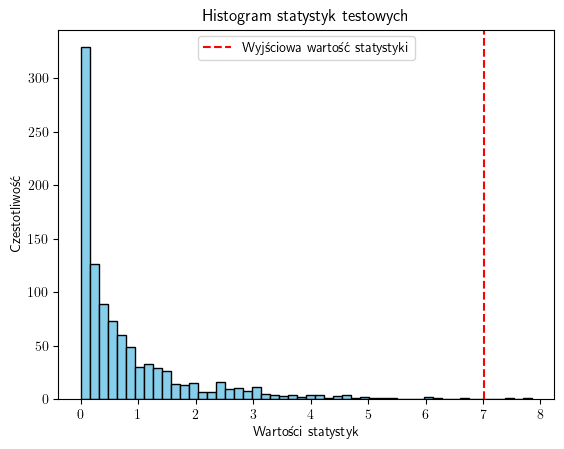

0.002

In [49]:
permutation_test(tfns_1, tfns_2, TFN_statistic, plot_histogram=True)

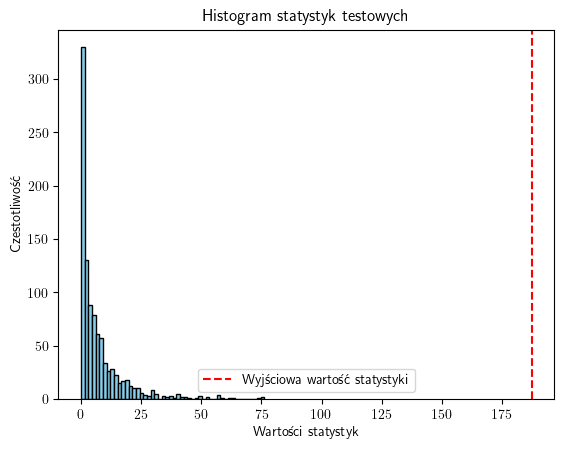

0.0

In [23]:
permutation_test(tfns_1, tfns_2, TFN_statistic_pgrzeg, plot_histogram=True)

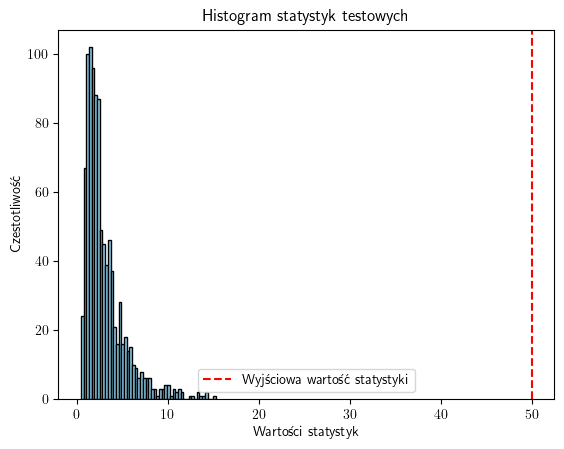

0.0

In [24]:
permutation_test(tfns_1, tfns_2, TFN_statistic_szekely, plot_histogram=True)

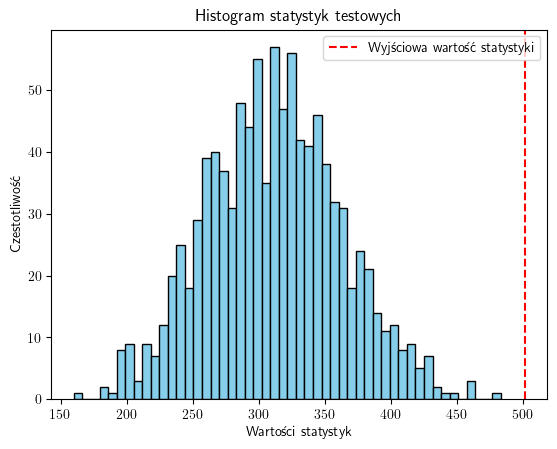

0.0

In [51]:
permutation_test(tfns_2, tfns_1, TFN_statistic_milena, plot_histogram=True)

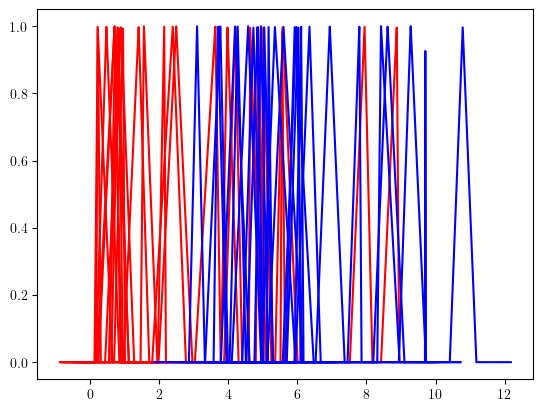

312.5
342.8316873244143


In [27]:
for tfn in tfns_1:
    tfn.plot(color='r')
for tfn in tfns_2:
    tfn.plot(color='b')

plt.show()

combined_samples = np.concatenate([tfns_1, tfns_2])

# Observed test statistic
observed_statistic =TFN_statistic_milena(tfns_1, tfns_1)
print(observed_statistic)

# Permute the combined samples
permuted_samples = np.random.permutation(combined_samples)

# Compute the test statistic for permuted samples
permuted_sample1 = permuted_samples[:len(tfns_1)]
permuted_sample2 = permuted_samples[len(tfns_1):]
permuted_statistics = TFN_statistic_milena(permuted_sample1, permuted_sample2)
print(permuted_statistics)

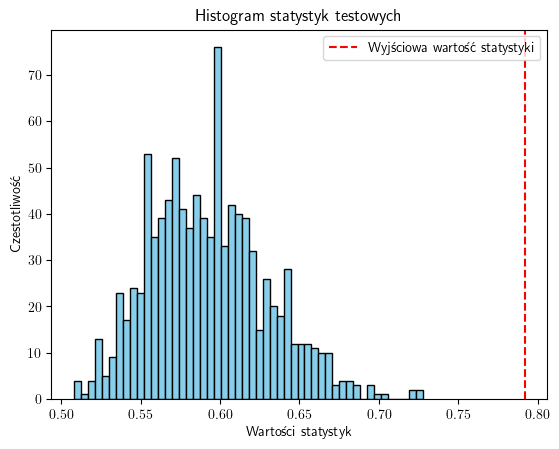

0.0

In [26]:
permutation_test_knn(tfns_1, tfns_2, plot_histogram=True)

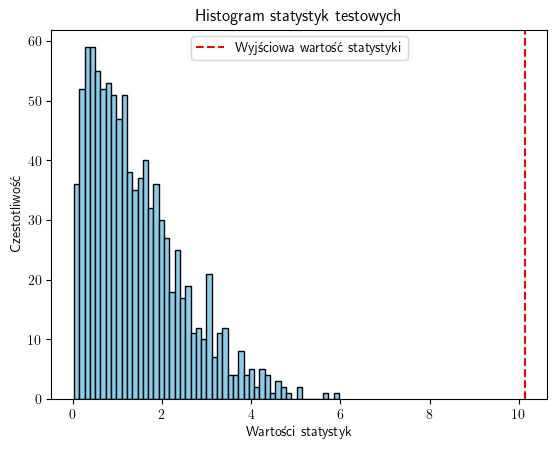

0.0

In [27]:
permutation_test(tfns_1, tfns_2, TFN_statistic_kozak, plot_histogram=True)

## $H_0$ prawdziwa - rozmiar testu

In [ ]:
def empirical_size(sample_pairs, dist_1, dist_2, test_statistic, num_tests=1000):
    results = []

    for (sample_size1, sample_size2) in sample_pairs:
        

        dist1_name = dist_1['name']
        dist1_params = dist_1['params']
        
        dist2_name = dist_2['name']
        dist2_params = dist_2['params']
        
        for _ in range(num_tests):
            # Generate samples

            sample1 = generate_TFN(dist1_name, **dist1_params)
            sample2 = generate_TFN(dist2_name, **dist2_params)
            
            # Perform permutation test
            p_value = permutation_test(sample1, sample2, test_statistic, num_permutations=1000)
            
            # Check if p-value is less than or equal to 0.05
            if p_value <= 0.05:
                results.append({
                    'sample_size1': sample_size1,
                    'sample_size2': sample_size2,
                    'empirical_size': 1
                })
            else:
                results.append({
                    'sample_size1': sample_size1,
                    'sample_size2': sample_size2,
                    'empirical_size': 0
                })
    
    df = pd.DataFrame(results)
    summary_table = df.groupby(['sample_size1', 'sample_size2']).agg(empirical_size=('empirical_size', 'mean')).reset_index()
    return summary_table

### Wyniki empiryczne

In [ ]:
dist_1 = {
    'name': 'norm',
    'params': {'loc': 0, 'scale': 1}
}

dist_2 = {
    'name': 'norm',
    'params': {'loc': 0, 'scale': 1}
}

sample_pairs = [(10,10), (10, 15), (15, 15), (20, 20), (20, 15), (25, 20), (25,25)] 
empirical_size(sample_pairs, dist_1, dist_2, TFN_statistic, num_tests=100)

,sample_size1,sample_size2,empirical_size
0,10,10,0.04
1,10,15,0.07
2,15,15,0.03
3,20,15,0.05
4,20,20,0.03
5,25,20,0.04
6,25,25,0.11


## $H_1$ prawdziwa - moc testu

Służy do liczenia mocy zadanego testu

### Moc od $\mu_2-\mu_1$

In [53]:
def calculate_power(dist, delta_1, delta_2, differences, 
                    test_statistic, sample_size=100,  
                    num_tests=1000, num_permutations=1000, 
                    return_power = False):
    
    dist1_name = dist['name']
    dist1_params = dist['params']

    dist2_params = dist1_params.copy()
    
    powers = []
    for difference in differences:
        
        num_rejections = 0
        for _ in range(num_tests):
            # Generate samples
            sample1 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist1_params)

            dist2_params['loc'] = dist1_params['loc'] + difference
            sample2 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist2_params)  # Increase mean for sample 2
            
            # Perform permutation test
            p_value = permutation_test(sample1, sample2, test_statistic, num_permutations=num_permutations)
            
            # Check if p-value is less than or equal to 0.05
            if p_value <= 0.05:
                num_rejections += 1
        
        power = num_rejections / num_tests
        powers.append(power)
    
    # Plot power vs difference between means
    plt.plot(differences, powers)
    plt.xlabel("$\mu_2-\mu_1$", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywa mocy", fontsize=16)
    plt.grid(True)
    #plt.show()

    if return_power:
        results = []
        
        results.append({
            'distribution': dist1_name, 
            'parameters': dist1_params,
            'differences': differences,
            'empirical_power': powers
                })
            
        df = pd.DataFrame(results)
        return df

#### Wyniki empiryczne

,distribution,parameters,differences,empirical_power
0,norm,"{'loc': 0, 'scale': 1}","[-1.0, -0.8947368421052632, -0.789473684210526...","[1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.5, 0.5, 0.5, ..."


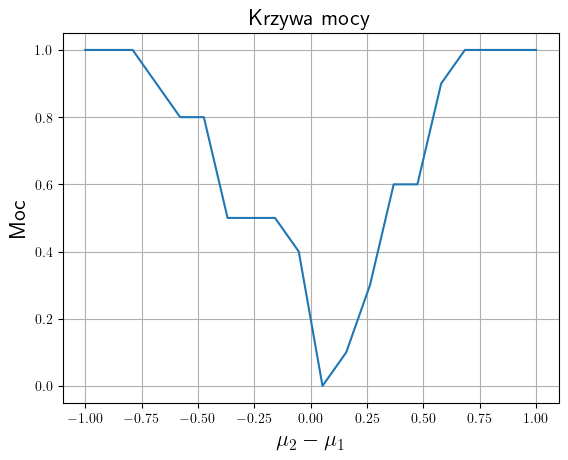

In [54]:
dist = {
    'name': 'norm',
    'params': {'loc':0, 'scale': 1}
}

differences = np.linspace(-1, 1, 20)  

calculate_power(dist, delta_1=0.25, delta_2=0.75,
                differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=10, 
                num_permutations=20, return_power = True)

In [ ]:
dist = {
    'name': 'norm',
    'params': {'loc':0, 'scale': 1}
}

differences = np.linspace(-1, 1, 20)  

calculate_power(dist, delta_1=0.25, delta_2=0.75,
                differences=differences, test_statistic=TFN_statistic_milena,
                sample_size=50,  num_tests=10, 
                num_permutations=20, return_power = True)

,distribution,parameters,differences,empirical_power
0,norm,"{'loc': 0, 'scale': 1}","[0.0, 0.034482758620689655, 0.0689655172413793...","[0.05, 0.046, 0.071, 0.076, 0.103, 0.135, 0.17..."


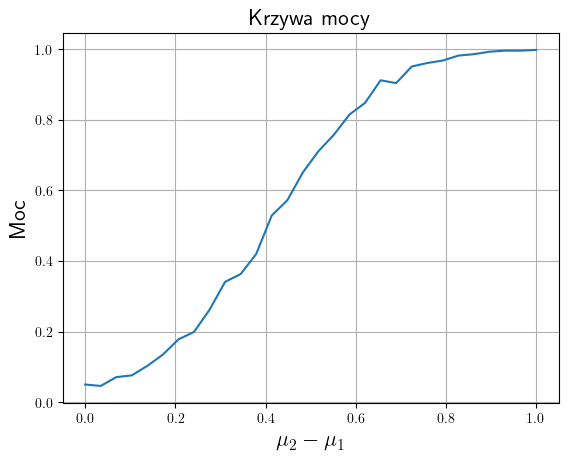

In [21]:
dist = {
    'name': 'norm',
    'params': {'loc':0, 'scale': 1}
}

differences = np.linspace(0, 1, 30)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,
                differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=1000, 
                num_permutations=1000, return_power = True)

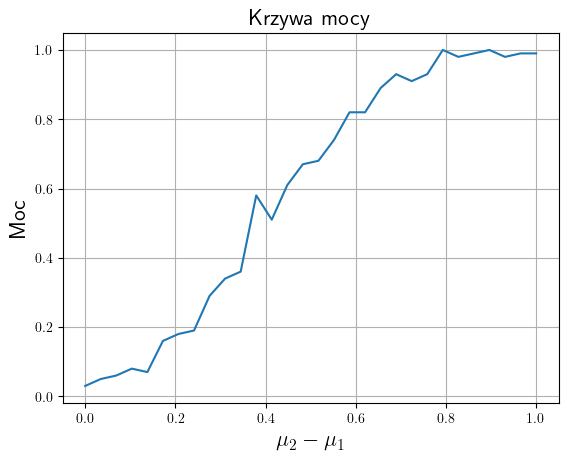

In [ ]:
dist = {
    'name': 'expon',
    'params': {'loc': 5, 'scale': 1}
}

differences = np.linspace(0, 1, 30)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=100, num_permutations=100, return_power = False)

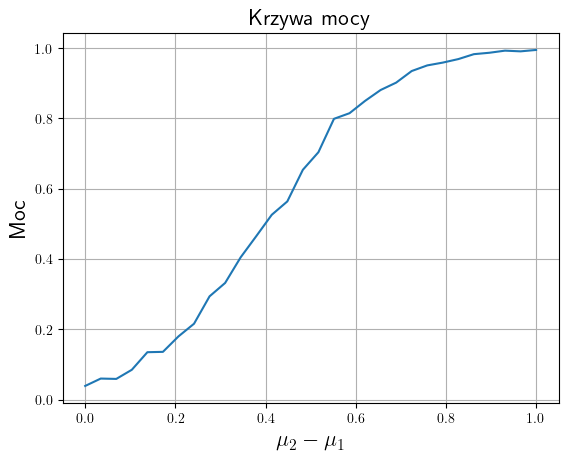

In [22]:
dist = {
    'name': 'expon',
    'params': {'loc': 0, 'scale': 1}
}

differences = np.linspace(0, 1, 30)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=1000, num_permutations=1000, return_power = False)

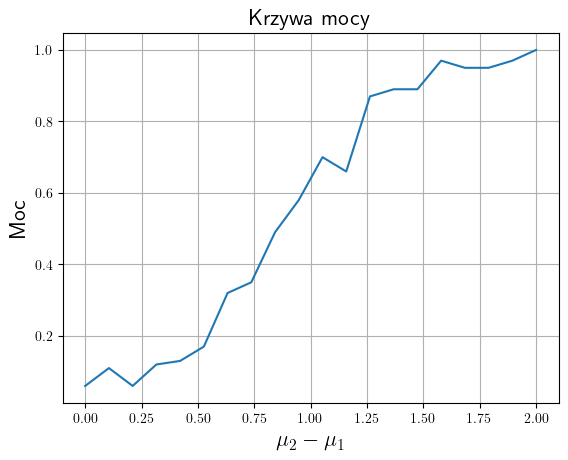

In [ ]:
dist = {
    'name': 'gamma',
    'params': {'a': 5, 'scale': 1, 'loc': 5}
}

differences = np.linspace(0, 2, 20)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=100, num_permutations=100, return_power = False)

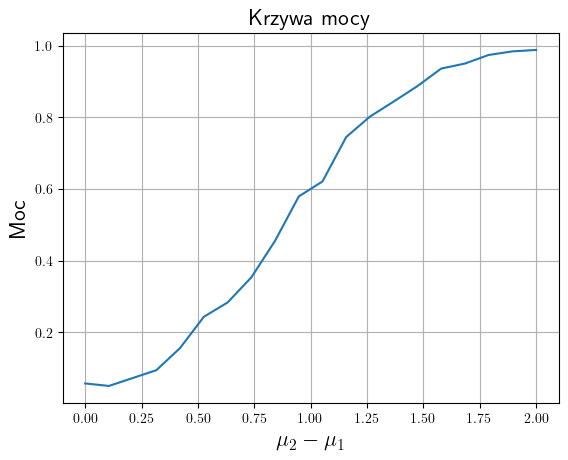

In [23]:
dist = {
    'name': 'gamma',
    'params': {'a': 5, 'scale': 1, 'loc': 0}
}

differences = np.linspace(0, 2, 20)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=1000, num_permutations=1000, return_power = False)

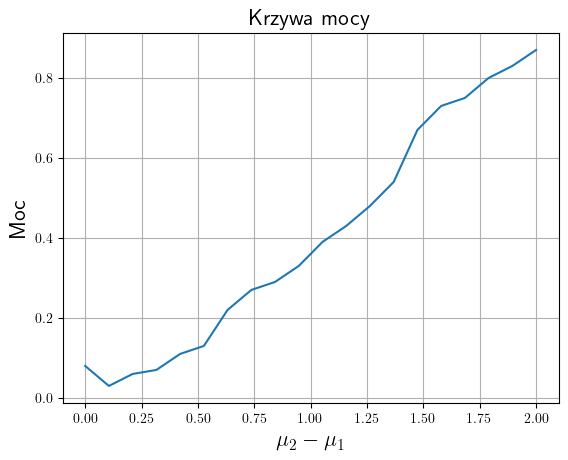

In [ ]:
dist = {
    'name': 'chi2',
    'params': {'df': 5, 'loc': 0}
}

differences = np.linspace(0, 2, 20)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=100, num_permutations=100, return_power = False)

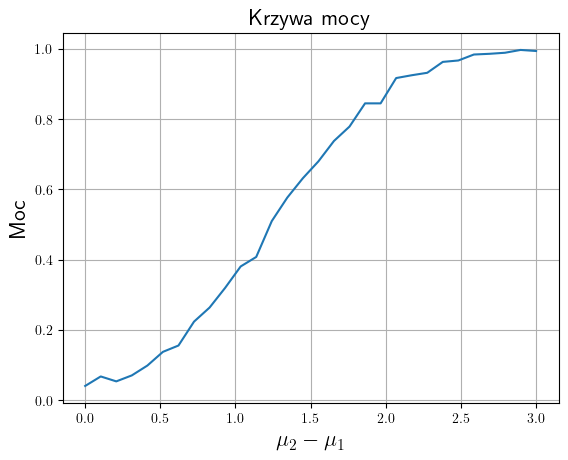

In [24]:
dist = {
    'name': 'chi2',
    'params': {'df': 5, 'loc': 0}
}

differences = np.linspace(0,3, 30)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=1000, num_permutations=1000, return_power = False)

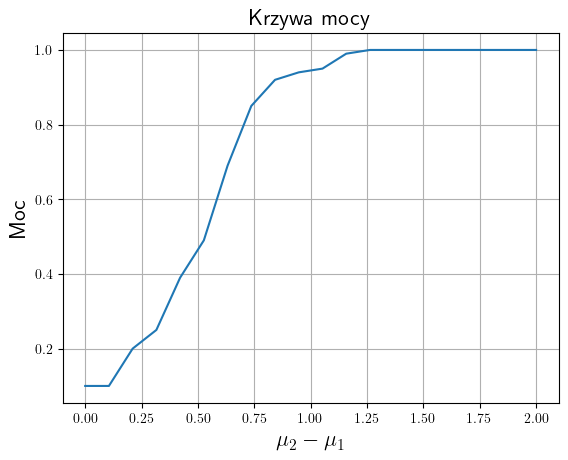

In [ ]:
dist = {
    'name': 't',
    'params': {'df': 5, 'loc': 0}
}

differences = np.linspace(0, 2, 20)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=100, num_permutations=100, return_power = False)

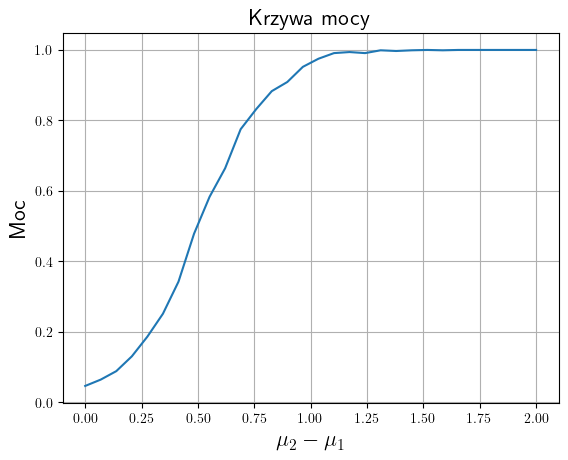

In [25]:
dist = {
    'name': 't',
    'params': {'df': 5, 'loc': 0}
}

differences = np.linspace(0, 2, 30)  

calculate_power(dist, delta_1=1.75, delta_2=2.25,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=1000, num_permutations=1000, return_power = False)

### Moc vs $\varepsilon$

In [26]:
def calculate_power_eps(dist, delta_1, delta_2, mixture_proportions, shift, test_statistic, 
                    sample_size=50,  num_tests=1000, num_permutations=1000, return_power = False):
    
    dist1_name = dist['name']
    dist1_params = dist['params']
    
    powers = []
    for proportion in mixture_proportions:        
        num_rejections = 0
        for _ in range(num_tests):

            # Generate samples
            sample1 = generate_TFN(dist1_name, delta_1, delta_2, sample_size,if_mixture=False, **dist1_params)
            sample2 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, if_mixture=True, mixture_proportion=proportion, shift=shift, **dist1_params)  # Increase mean for sample 2
            
            # Perform permutation test
            p_value = permutation_test(sample1, sample2, test_statistic, num_permutations=num_permutations)
            
            # Check if p-value is less than or equal to 0.05
            if p_value <= 0.05:
                num_rejections += 1
        
        power = num_rejections / num_tests
        powers.append(power)
    
    # Plot power vs difference between means
    plt.plot(mixture_proportions, powers)
    plt.xlabel("$\epsilon $", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywa mocy", fontsize=16)
    plt.grid(True)
    #plt.show()

    if return_power:
        results = []
        

        results.append({
            'distribution': dist1_name, 
            'parameters': dist1_params,
            'mixture_proportions': mixture_proportions,
            'empirical_power': powers
                })
            
        df = pd.DataFrame(results)
        return df

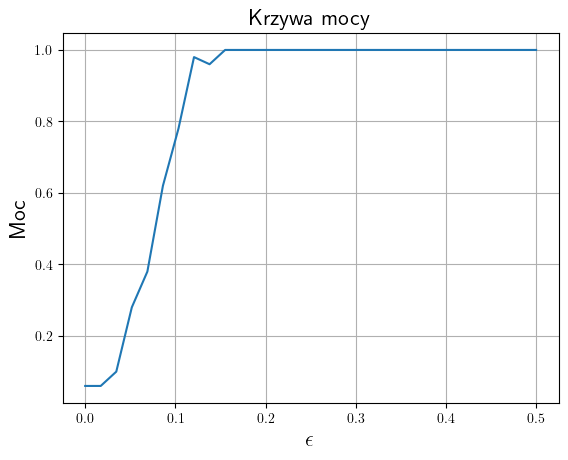

In [ ]:
dist = {
    'name': 'norm',
    'params': {'loc': 0, 'scale': 1}
}

delta_1 = 1.75
delta_2 = 2.25
mixture_proportions = np.linspace(0, 0.5, 30)
shift = 10

calculate_power_eps(dist, delta_1, delta_2, mixture_proportions, shift, TFN_statistic, 
                    sample_size=50,  num_tests=50, num_permutations=50, return_power = False)

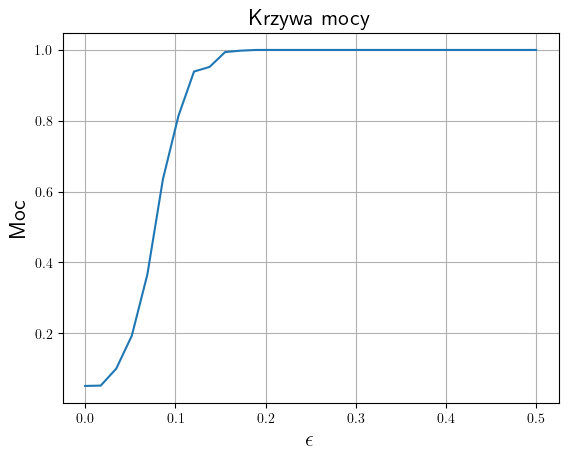

In [27]:
dist = {
    'name': 'norm',
    'params': {'loc': 0, 'scale': 1}
}

delta_1 = 1.75
delta_2 = 2.25
mixture_proportions = np.linspace(0, 0.5, 30)
shift = 10

calculate_power_eps(dist, delta_1, delta_2, mixture_proportions, shift, TFN_statistic, 
                    sample_size=50,  num_tests=1000, num_permutations=1000, return_power = False)

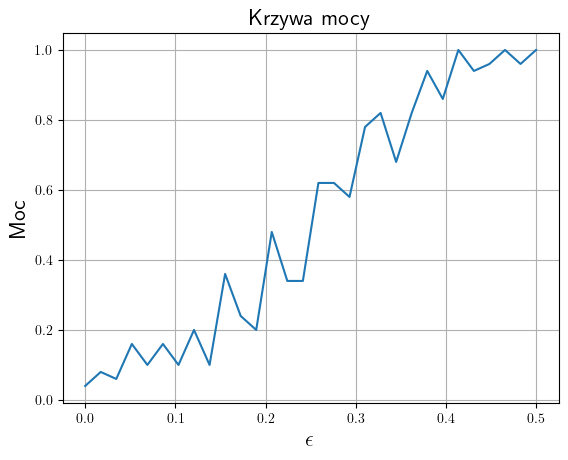

In [ ]:
dist = {
    'name': 'chi2',
    'params': {'df': 4, 'loc': 0}
}

delta_1 = 0.5
delta_2 = 0.5
mixture_proportions = np.linspace(0, 0.5, 30)
shift = 10

calculate_power_eps(dist, delta_1, delta_2, mixture_proportions, shift, TFN_statistic, 
                    sample_size=20,  num_tests=50, num_permutations=50, return_power = False)

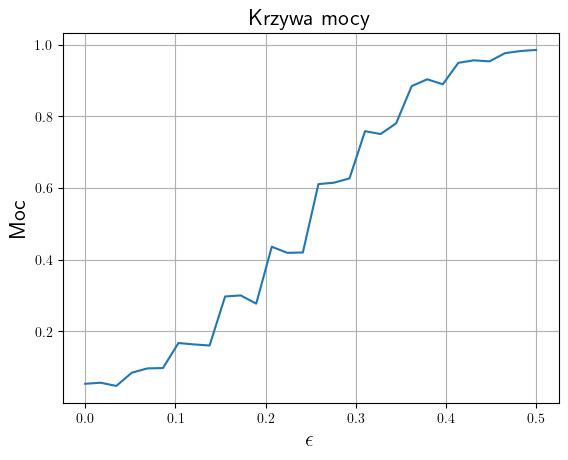

In [28]:
dist = {
    'name': 'chi2',
    'params': {'df': 4, 'loc': 0}
}

delta_1 = 0.5
delta_2 = 0.5
mixture_proportions = np.linspace(0, 0.5, 30)
shift = 10

calculate_power_eps(dist, delta_1, delta_2, mixture_proportions, shift, TFN_statistic, 
                    sample_size=20,  num_tests=1000, num_permutations=1000, return_power = False)

### Moc vs $\sigma$

In [29]:
def calculate_power_sigma(dist, delta_1, delta_2, differences, test_statistic, 
                    sample_size=100,  num_tests=1000, num_permutations=1000, return_power = False):
    
    dist1_name = dist['name']
    dist1_params = dist['params']

    dist2_params = dist1_params.copy()
    
    powers = []
    for difference in differences:
        
        num_rejections = 0
        for _ in range(num_tests):
            # Generate samples
            sample1 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist1_params)

            dist2_params['scale'] = dist1_params['scale'] + difference
            sample2 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist2_params)  # Increase scale for sample 2
            
            # Perform permutation test
            p_value = permutation_test(sample1, sample2, test_statistic, num_permutations=num_permutations)
            
            # Check if p-value is less than or equal to 0.05
            if p_value <= 0.05:
                num_rejections += 1
        
        power = num_rejections / num_tests
        powers.append(power)
    
    # Plot power vs difference between means
    plt.plot(differences, powers)
    plt.xlabel("$ \sigma_2-\sigma_1$", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywa mocy", fontsize=16)
    plt.grid(True)
    #plt.show()

    if return_power:
        results = []
        
        results.append({
            'dist': dist1_name,
            'parameters': dist1_params,
            'sigma differences': differences,
            'empirical_power': powers
                })
            
        df = pd.DataFrame(results)
        return df

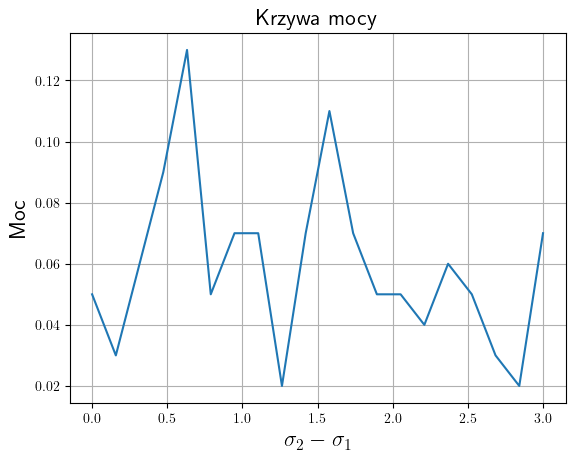

In [ ]:
dist = {
    'name': 'norm',
    'params': {'loc': 0, 'scale': 1}
}

differences = np.linspace(0, 3, 20)  

calculate_power_sigma(dist, delta_1=0.75, delta_2=0.6,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=100, num_permutations=100, return_power = False)

In [ ]:
dist = {
    'name': 'norm',
    'params': {'loc': 0, 'scale': 1}
}

differences = np.linspace(0, 3, 20)  

calculate_power_sigma(dist, delta_1=0.75, delta_2=0.6,differences=differences, test_statistic=TFN_statistic,
                sample_size=50,  num_tests=1000, num_permutations=1000, return_power = False)

# Porównanie testów

## Porównanie mocy testów: Moc vs $\mu_2-\mu_1$

In [ ]:
tests = ['jkulesza', 'pgrzeg', 'knn', 'gszekely', 'mzacharczuk', 'akozak']

In [30]:
def calculate_multiple_powers(dist, delta_1, delta_2, differences, sample_size=50, num_tests=1000, 
                                num_permutations=1000, return_power=False, selected_tests=None):
    
    powers = {f'{test}': [] for test in selected_tests}
    
    dist1_name = dist['name']
    dist1_params = dist['params']
    dist2_params = dist1_params.copy()
    
    for difference in differences:
        
        rejections = {f'{test}': 0 for test in selected_tests}
        
        for _ in range(num_tests):
            
            sample1 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist1_params)
            dist2_params['loc'] =  dist1_params['loc'] + difference
            sample2 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist2_params) 
            for test in selected_tests:
                if test == 'knn':
                    p_value = permutation_test_knn(sample1, sample2, num_permutations=num_permutations)

                if test == 'jkulesza':
                    p_value = permutation_test(sample1, sample2, TFN_statistic, num_permutations=num_permutations)
                    
                if test == 'pgrzeg':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_pgrzeg, num_permutations=num_permutations)

                if test == 'gszekely':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_szekely, num_permutations=num_permutations)
                        
                if test == 'mzacharczuk':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_milena, num_permutations=num_permutations)

                if test == 'akozak':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_kozak, num_permutations=num_permutations)

                if p_value <= 0.05:
                    rejections[test] += 1

        for test in selected_tests:        
            powers[test].append(rejections[test] / num_tests)

    colors = {"jkulesza":"r", "pgrzeg":"g", "knn":"b", "gszekely":"m", "mzacharczuk":"c", "akozak":"orange"}
    for test in selected_tests: 
        plt.plot(differences, powers[test], colors[test], label = test)

    plt.xlabel("$\mu_2-\mu_1$", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywe mocy", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

    if return_power:

        results = {f'{test}': [] for test in selected_tests}
        dfs = {f'{test}': [] for test in selected_tests}

        for test in selected_tests:

            results[test].append({
                'dist': dist1_name,
                'parameters': dist1_params,
                'differences': differences,
                'empirical_power': powers[test]
                })

            dfs[test] = pd.DataFrame(results[test])        
        
        
        return dfs

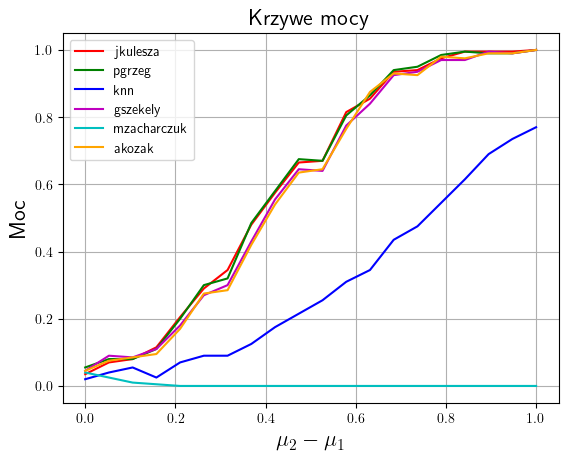

In [31]:
dist = {
    'name': 'norm',
    'params': {'loc':5, 'scale': 1}
}

differences = np.linspace(0, 1, 20)  
selected_tests = ['jkulesza', 'pgrzeg', 'knn', 'gszekely', 'mzacharczuk', 'akozak']
dfs = calculate_multiple_powers(dist, delta_1=1.75, delta_2 = 2.25, differences=differences, sample_size=50, num_tests=200, num_permutations=200, 
return_power=True, selected_tests = selected_tests)

In [ ]:
for test in selected_tests:    
    dfs[test].to_csv('power_data_'+test+'.csv', index=False) 

## Moc vs $\varepsilon$

In [32]:
def calculate_multiple_powers_eps(dist, delta_1, delta_2, mixture_proportions, shift, sample_size=50, num_tests=1000, 
                                num_permutations=1000, return_power=False, selected_tests=None):
    
    powers = {f'{test}': [] for test in selected_tests}
    
    dist1_name = dist['name']
    dist1_params = dist['params']
    
    for proportion in mixture_proportions:   
        
        rejections = {f'{test}': 0 for test in selected_tests}
        
        for _ in range(num_tests):
            
            sample1 = generate_TFN(dist1_name, delta_1, delta_2, sample_size,if_mixture=False, **dist1_params)
            sample2 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, if_mixture=True, mixture_proportion=proportion, shift=shift, **dist1_params) 

            for test in selected_tests:
                if test == 'knn':
                    p_value = permutation_test_knn(sample1, sample2, num_permutations=num_permutations)

                if test == 'jkulesza':
                    p_value = permutation_test(sample1, sample2, TFN_statistic, num_permutations=num_permutations)
                    
                if test == 'pgrzeg':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_pgrzeg, num_permutations=num_permutations)

                if test == 'gszekely':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_szekely, num_permutations=num_permutations)
                        
                if test == 'mzacharczuk':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_milena, num_permutations=num_permutations)

                if test == 'akozak':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_kozak, num_permutations=num_permutations)

                if p_value <= 0.05:
                    rejections[test] += 1

        for test in selected_tests:        
            powers[test].append(rejections[test] / num_tests)

    colors = {"jkulesza":"#ff595e", "pgrzeg":"#ff924c", "knn":"#ffca3a", "gszekely":"#8ac926", "mzacharczuk":"#1982c4", "akozak":"#6a4c93"}
    for test in selected_tests: 
        plt.plot(mixture_proportions, powers[test], colors[test], label = test)

    plt.xlabel("$\epsilon $", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywe mocy", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

    if return_power:

        results = {f'{test}': [] for test in selected_tests}
        dfs = {f'{test}': [] for test in selected_tests}

        for test in selected_tests:

            results[test].append({
                'dist': dist1_name,
                'parameters': dist1_params,
                'mixture_proportions': mixture_proportions,
                'empirical_power': powers[test]
                })

            dfs[test] = pd.DataFrame(results[test])        
        
        
        return dfs

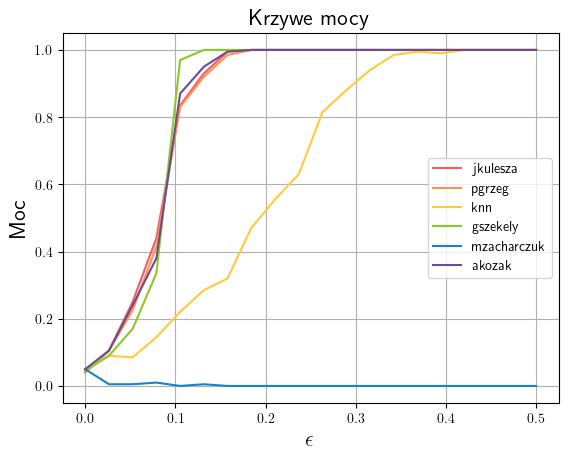

In [33]:
dist = {
    'name': 'norm',
    'params': {'loc':5, 'scale': 1}
}
delta_1 = 1.75
delta_2 = 2.25
mixture_proportions = np.linspace(0, 0.5, 20)
shift = 10

selected_tests = ['jkulesza', 'pgrzeg', 'knn', 'gszekely', 'mzacharczuk', 'akozak']
dfs = calculate_multiple_powers_eps(dist, delta_1, delta_2, mixture_proportions, shift, sample_size=50, num_tests=200, num_permutations=200, 
return_power=True, selected_tests = selected_tests)

## Moc vs $\sigma$

In [34]:
def calculate_multiple_powers_sigma(dist, delta_1, delta_2, differences, sample_size=50, num_tests=1000, 
                                num_permutations=1000, return_power=False, selected_tests=None):
    
    powers = {f'{test}': [] for test in selected_tests}
    
    dist1_name = dist['name']
    dist1_params = dist['params']
    dist2_params = dist1_params.copy()
    
    for difference in differences:
        
        rejections = {f'{test}': 0 for test in selected_tests}
        
        for _ in range(num_tests):
            
            sample1 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist1_params)

            dist2_params['scale'] = dist1_params['scale'] + difference
            sample2 = generate_TFN(dist1_name, delta_1, delta_2, sample_size, **dist2_params)  

            for test in selected_tests:
                if test == 'knn':
                    p_value = permutation_test_knn(sample1, sample2, num_permutations=num_permutations)

                if test == 'jkulesza':
                    p_value = permutation_test(sample1, sample2, TFN_statistic, num_permutations=num_permutations)
                    
                if test == 'pgrzeg':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_pgrzeg, num_permutations=num_permutations)

                if test == 'gszekely':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_szekely, num_permutations=num_permutations)
                        
                if test == 'mzacharczuk':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_milena, num_permutations=num_permutations)

                if test == 'akozak':
                    p_value = permutation_test(sample1, sample2, TFN_statistic_kozak, num_permutations=num_permutations)

                if p_value <= 0.05:
                    rejections[test] += 1

        for test in selected_tests:        
            powers[test].append(rejections[test] / num_tests)

    colors = {"jkulesza":"r", "pgrzeg":"g", "knn":"b", "gszekely":"m", "mzacharczuk":"c", "akozak":"orange"}
    for test in selected_tests: 
        plt.plot(differences, powers[test], colors[test], label = test)

    plt.xlabel("$ \sigma_2-\sigma_1$", fontsize=16)
    plt.ylabel("Moc", fontsize=16)
    plt.title("Krzywe mocy", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

    if return_power:

        results = {f'{test}': [] for test in selected_tests}
        dfs = {f'{test}': [] for test in selected_tests}

        for test in selected_tests:

            results[test].append({
                'dist': dist1_name,
                'parameters': dist1_params,
                'sigma differences': differences,
                'empirical_power': powers[test]
                })

            dfs[test] = pd.DataFrame(results[test])        
        
        
        return dfs

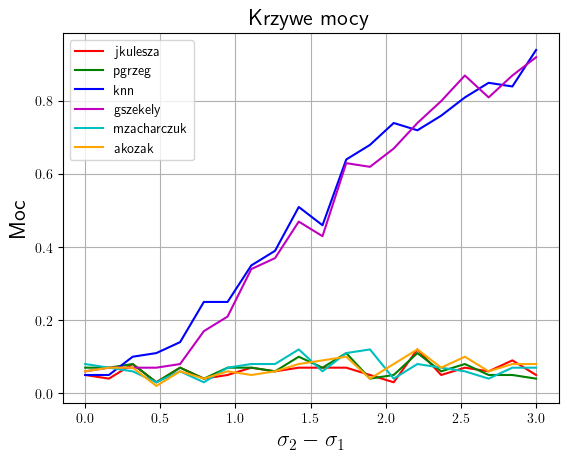

In [35]:
dist = {
    'name': 'norm',
    'params': {'loc': 0, 'scale': 1}
}

delta_1 = 1.75
delta_2 = 2.25
sigma_differences = np.linspace(0, 3, 20)  
selected_tests = ['jkulesza', 'pgrzeg', 'knn', 'gszekely', 'mzacharczuk', 'akozak']


calculate_multiple_powers_sigma(dist, delta_1, delta_2,differences=sigma_differences,
                sample_size=20, num_tests=100, num_permutations=100, return_power=False, selected_tests=selected_tests)